In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_40/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Práctica Guiada

## La Maldición de la Dimensionalidad y Feature Selection

<a id="section_TOC"></a> 

#### Tabla de Contenidos
[1- Primera parte: La maldicion de la dimensionalidad](#section_maldicion)

$\hspace{.5cm}$[1.1- Ejercicio: proporción de outliers](#section_outliers)

$\hspace{.5cm}$[1.2- Caso de análisis: clasificación](#section_clasificacion)


[2- Segunda parte: Feature selection](#section_feature_selection)

$\hspace{.5cm}$[2.1- Filter methods](#section_filter)

$\hspace{1cm}$[2.1.1- Features con baja varianza](#section_varianza)

$\hspace{1cm}$[2.1.2- Select K-Best](#section_kbest)

$\hspace{1cm}$[2.1.3- Select K-Percentile](#section_kpercentile)

$\hspace{.5cm}$[2.2- Wrapper methods](#section_wrapper)

$\hspace{1cm}$[2.2.1- Eliminación Recursiva de Features (RFE)](#section_rfe)

$\hspace{1cm}$[2.2.2- Eliminación Recursiva de Features con cross validation (RFECV)](#section_rfecv)

$\hspace{.5cm}$[2.3- Feature Selection como parte de un pipeline](#section_pipeline)

$\hspace{.5cm}$[2.4- Algoritmos genéticos](#section_genetic)



In [2]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


<a id="section_maldicion"></a> 

## 1- Primera Parte: La maldición de la dimensionalidad
[Volver al índice](#section_TOC)


<a id="section_outliers"></a> 

### 1.1- Proporción de outliers

Empecemos con un ejercicio: si tenemos una variable distribuida uniformemente en un hipercubo de $d$ dimensiones, ¿qué propoción de outliers esperamos encontrar? 

Podemos definir outliers como aquellos puntos que toman valores extremos en alguna de las $d$ dimensiones. 

Por ejemplo, si pensamos en dos dimensiones, se nos forma un marco cuadrado:

Número de outliers: 18  de  500


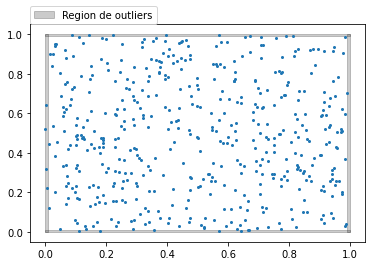

In [3]:
N=500;

X=np.random.uniform(size=(N,2)); # generamos 500 puntos en un espacio de dos dimensiones, distribuidos uniformemente

plt.plot(X[:,0],X[:,1],'o',ms=2)
x = [0.0,1.0]
p = 0.01 # Si alguna de las coordenadas está en el percentil 1 o 99 del eje, lo consideramos un outlier

plt.fill_between(x,0,p,alpha=0.2,color='k')
plt.fill_between(x,1-p,1,alpha=0.2,color='k')
plt.fill_betweenx(x,0,p,alpha=0.2,color='k')
plt.fill_betweenx(x,1-p,1,alpha=0.2,color='k',label='Region de outliers');
plt.legend(loc=(0,1));

n_outliers=np.sum(np.sum((X <p) |( X >(1-p)),axis=1));

print('Número de outliers:',n_outliers, ' de ',N)

Ahora bien, ¿qué pasa a medida que aumentamos la dimensionalidad del dataset? Dado que no podemos graficar en más de tres dimensiones, lo que haremos será graficar la evolución de la proporción de outliers para cada nivel de dimensionalidad.

Antes de ejecutar la siguiente celda, piensen qué esperan encontrar.


<img src='img/source.gif'>


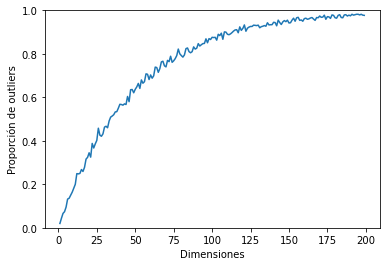

In [4]:

N=1000;
p=0.01;
Ds=np.arange(1,200);
p_outliers=[];
for d in Ds:
    X=np.random.uniform(size=(N,d));
    p_outliers.append(np.mean(np.any((X <p) |( X >(1-p)),axis=1)))

plt.plot(Ds, p_outliers);
plt.ylim([0,1])
plt.ylabel('Proporción de outliers')
plt.xlabel('Dimensiones');

* ¿Qué observan?
* ¿Qué sucede con la proporción de outliers a medida que el espacio de predictores se incrementa en dimensionalidad?
* ¿Cómo lo explican?

El número de outliers aumenta porque, al agregar dimensiones, aumenta la probabilidad de que en <b>al menos una dimensión </b> la variable tome un valor extremo.

En el caso que vimos recién los datos estaban distribuidos uniformemente. En datos de la vida real probablemente esto no sea así, sino que esperamos que haya alguna estructura en el espacio de las features. Es decir, que haya grupos de datos más parecidos entre sí (clusters), correlación entre algunas features, etc. En cualquier problema de machine learning uno quiere aprender esa estructura de los datos. Si agregamos features, es esperable que los datos se alejen entre sí en el espacio ampliado por las nuevas dimensiones. Separar los puntos en un espacio de mayor dimensionalidad puede servir para revelar una estructura, pero si nos pasamos de rosca puede tener el efecto inverso: que se pierda la estructura en un espacio demasiado grande.

Por este motivo la performance de los algoritmos dependerá de la dimensionalidad de los datos, y encontrar la dimensionalidad óptima se puede considerar un problema de optimización de hiperparámetros, abordable por medio de cross validation.

Repasemos estos conceptos con un ejemplo.

<a id="section_clasificacion"></a> 

### 1.2- Caso de análisis: clasificación

[Volver al índice](#section_TOC)

A continuación vamos a ver qué sucede con la performance de una regresión logística sin regularización a medida que aumenta la cantidad de dimensiones.

La regresión deberá predecir datos simulados a través de distribuciones normales multivariadas.

* La clase 0 tendrá media 0 y las varianzas de todas las dimensiones valdrán 0.5
* La clase 1 tendrá media 1 y las varianzas de todas las dimensiones valdrán 0.5

En una y en dos dimensiones, los datos se verían así:

In [5]:
d=2
size0 =int(np.round(0.5*N)) ; size1 = N-size0;
loc0 = np.ones(d); loc1 = np.zeros(d);
sigma0 = 0.5; sigma1 = 0.5; 
C0 = sigma0*np.diag(np.ones(d)); C1 = sigma1*np.diag(np.ones(d))
loc0

array([1., 1.])

<AxesSubplot:>

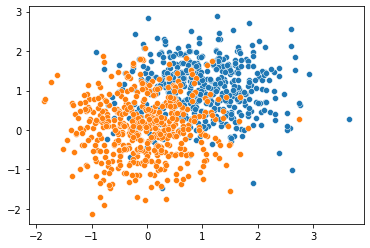

In [6]:
X=np.random.multivariate_normal(loc0,C0,size0)
sns.scatterplot(x=X[:,0],y=X[:,1])
Y=np.random.multivariate_normal(loc1,C1,size1)
sns.scatterplot(x=Y[:,0],y=Y[:,1])



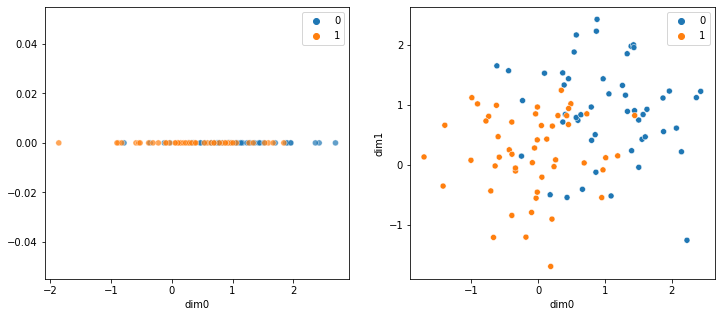

In [7]:
def dos_multinormales(d,N):
    # d es el número de dimensiones, N el número de puntos. Las clases estarán balanceadas.
    size0 =int(np.round(0.5*N)) ; size1 = N-size0;
    loc0 = np.ones(d); loc1 = np.zeros(d);
    sigma0 = 0.5; sigma1 = 0.5; 
    C0 = sigma0*np.diag(np.ones(d)); C1 = sigma1*np.diag(np.ones(d))
    
    #Generamos datos multivariados
    x0 = np.random.multivariate_normal(loc0,C0,size0);
    x1 = np.random.multivariate_normal(loc1,C1,size1);
    X=np.concatenate((x0,x1),axis=0)
    #Creamos la matriz de features
    dfX = pd.DataFrame(X);
    dfX.columns = ['dim'+str(i) for i in range(d)];
    dfX['class']=0
    dfX.loc[x0.shape[0]:,'class']=1
    return dfX

ax=plt.subplots(nrows=1,ncols=2,figsize=(12,5));



dfX=dos_multinormales(1,100);

hue_data = dfX['class'].values

sns.scatterplot(data=dfX,x='dim0',y=np.zeros(len(dfX)),hue=hue_data,alpha=.7,ax=ax[1][0]);

dfX=dos_multinormales(2,100);
sns.scatterplot(data=dfX,x='dim0',y='dim1',hue=hue_data,ax=ax[1][1]);


#### Regresión logística sobre datos de distintas dimensiones

Generamos una lista de posibles dimensiones y para cada uno de estos valores generamos un dataset simulado con las características descriptas arriba.

Sobre estos datos corremos y evaluamos una regresión logística para cada dimensionalidad. La métrica de evaluación será el promedio del score de test, utilizando cross validation con una partición de 5 folds en todos los casos. 

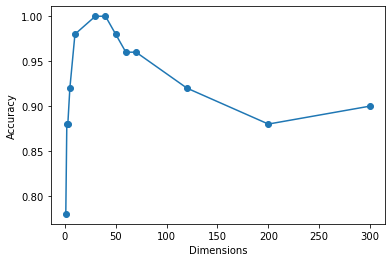

In [8]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model  import LogisticRegression
score = []
# Evaluamos el modelo en todas estas dimensiones
ds = [1,2,3,5,10,30,40,50,60,70,120,200,300]
N=50;
np.random.seed(1)

for d  in ds:
    dfX=dos_multinormales(d,N);    
    X = dfX.drop('class',axis=1)
    y = dfX['class']    
    # Guardamos la media del score de cross-validation
    model = LogisticRegression(C = 1e10,n_jobs=4);
    kf = KFold(5, shuffle=True, random_state=0);
    score.append(np.mean(cross_val_score(model,X,y,cv=kf)));
    
plt.plot(ds,score,'o-');
plt.ylabel('Accuracy')
plt.xlabel('Dimensions');

Observamos que a partir de cierta cantidad de dimensiones, la performance empieza a caer fuertemente debido al exceso de dimensiones en relación a la cantidad de datos disponibles. Si el volumen de datos aumenta, la cantidad óptima de dimensiones también aumenta.

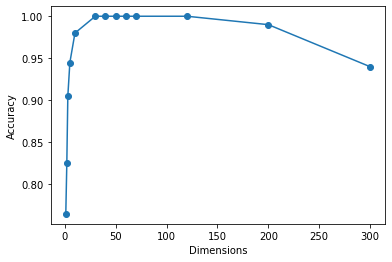

In [9]:
score = []
# Evaluamos el modelo en todas estas dimensiones
ds = [1,2,3,5,10,30,40,50,60,70,120,200,300]
N=200;
np.random.seed(1)
for d  in ds:
    dfX=dos_multinormales(d,N);    
    X = dfX.drop('class',axis=1)
    y = dfX['class']    
    # Guardamos la media del score de cross-validation
    model = LogisticRegression(C = 1e10,n_jobs=4);
    kf = KFold(5, shuffle=True, random_state=0);
    score.append(np.mean(cross_val_score(model,X,y,cv=kf)));
    
plt.plot(ds,score,'o-');
plt.ylabel('Accuracy')
plt.xlabel('Dimensions');



<a id="section_feature_selection"></a> 

## 2- Segunda Parte: Feature Selection

[Volver al índice](#section_TOC)

Por lo discutido hasta aquí, dado que los datos disponibles para entrenar nuestros modelos son finitos, muchas veces convendrá reducir la dimensionalidad de los mismos para evitar el overfitting y optimizar la performance del modelo. En el ejemplo anterior, el problema se reducía a agregar o quitar dimensiones independientes e igualmente relevantes entre sí, dado que estábamos generando datos multinormales con idéntica varianza y media en todas las dimensiones. En un dataset real, sin embargo, no esperamos que todas las dimensiones (features) sean igualmente relevantes. 

¿Cómo hacemos entonces para decidir cuál subset de features optimiza la performance de nuestro modelo?

Un abordaje de fuerza bruta a esta pregunta sería probar todas las combinaciones posibles de features y elegir la que de un mejor score en cross validation. El problema es que si tenemos n features, el número de subsets posibles escala como $2^n$ y rápidamente se vuelve impracticable el cómputo. Por otro lado, cuando el número de modelos que estamos comparando es muy grande para el tamaño de nuestro dataset, corremos el riesgo de hacer overfitting aún cuando estemos haciendo cross validation.

Veremos a continuación algunas técnicas alternativas para hacer selección de features. Para ello veremos algunos métodos implementados en Scikit-Learn. Pueden ahondar en sus variantes en la [documentación oficial del Scikit-Learn dedicada al tema](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

Existen diferentes "familias" de técnicas de feature selection. Veamos.




<a id="section_filter"></a> 

### 2.1 Filter Methods

[Volver al índice](#section_TOC)

Esta familia de métodos consiste en seleccionar features por sus propiedades estadísticas y su relación con la variable objetivo. Veremos a continuación algunos ejemplus univariados, es decir que no contemplan la covarianza entre features.


<a id="section_varianza"></a> 
#### 2.1.1 Features con baja varianza

Un primer caso (casi trivial) sería la remoción de aquellos features o características que no aporten "información" a nuestro dataset. Una forma de lograr la información es a través de la varianza. 

Entonces, lo que haremos será remover todos aquellos features que tengan baja varianza (es decir, baja variabilidad). Esto haremos definiendo un `threshold` por debajo del cual eliminaremos los features.


In [10]:
import pandas as pd
from scipy import random
import numpy as np
from sklearn import datasets

In [11]:
# Importamos los datasets Iris y Boston, que ya conocemos:

iris = datasets.load_iris()
boston = datasets.load_boston()


In [12]:
# Empecemos a trabajar con el dataset Iris. Creamos un DataFrame con los datos:

df1 = pd.DataFrame(np.concatenate((iris.data, iris.target.reshape(-1,1)),1),
                  columns = iris.feature_names + ['species'])

* Si aplicásemos un `threshold = 0.5` la única variable que debería ser excluida sería `sepal_width`:

In [13]:
df1.apply(np.var)

sepal length (cm)    0.681122
sepal width (cm)     0.188713
petal length (cm)    3.095503
petal width (cm)     0.577133
species              0.666667
dtype: float64

In [14]:
from sklearn.feature_selection import VarianceThreshold

# Instanciamos la clase VarianceThreshold definiendo un threshold=0.5

fet_sel = VarianceThreshold(threshold=0.5)

# Fiteamos a fet_sel con nuestro df1:

fet_sel.fit(df1)

VarianceThreshold(threshold=0.5)

* Usando el método `get_support` podemos consultar un array booleano que marca las variables que no han sido excluidas.

In [15]:
fet_sel.get_support()

array([ True, False,  True,  True,  True])

In [16]:
# Podemos filtrar las columnas que no superen el umbral de varianza:

df1.columns[fet_sel.get_support()]

Index(['sepal length (cm)', 'petal length (cm)', 'petal width (cm)',
       'species'],
      dtype='object')

* Si quisiéramos generar un nuevo array con los datos, simplemente podemos llamar al método `.transform(X)`

In [17]:
df1_reduced = pd.DataFrame(fet_sel.transform(df1), columns = df1.columns[fet_sel.get_support()])
df1_reduced.head()

,sepal length (cm),petal length (cm),petal width (cm),species
0,5.1,1.4,0.2,0.0
1,4.9,1.4,0.2,0.0
2,4.7,1.3,0.2,0.0
3,4.6,1.5,0.2,0.0
4,5.0,1.4,0.2,0.0



<a id="section_kbest"></a> 
#### 2.1.2 Select K-best
[Volver al índice](#section_TOC)


Este método toma dos argumentos:

* `score_func`: una función que devuelve algún score entre $X$ y $Y$:

    * Para regresión: f_regression, mutual_info_regression
    * Para clasificación: f_classif, mutual_info_classif


* `k`: la cantidad de "mejores" features que serán seleccionadas


#### `F- Test`


Tanto f_regression como f_classif se basan en un test estadístico llamado F-test. 

En el caso de <b>clasificación</b>, la hipótesis nula del test es que agrupar los datos por categorías no permite explicar una fracción significativa de la varianza de los datos, por este motivo al test se lo conoce como análisis de varianza (ANOVA). El test funciona de esta manera: dados los datos, se construye un estadístico llamado F de la siguiente forma

\begin{align}
F=&\frac{\text{explained variance}}{\text{unexplained variance}} = \frac{\text{between group variability}}{\text{within group variability}}\\
    &=\frac{ \frac{1}{K-1}\sum_{i=1}^K n_i (\bar{X}_i-\bar{X})^2 }{\frac{1}{N-K}\sum_{i=1}^K \sum_{j=1}^{n_i} (X_{ij}-\bar{X}_i)^2}
\end{align}

en donde $K$ es el número de grupos (clases),$N$ es el tamaño de la muestra, $n_i$ es la cantidad de observaciones dentro de la clase i-ésima, $\bar{X}$ es el valor medio de toda la muestra y $\bar{X}_i$ es el promedio dentro de la clase i-ésima.

Bajo la hipótesis nula, si además se cumplen los requisitos de normalidad y homosedasticidad (igual varianza entre los grupos), entonces el estadístico F sigue una distribución conocida (F-distribution). De esta forma si F se aparta mucho del valor esperado dada esa distribución, podemos rechazar la hipótesis nula. El p-valor es un estadístico que indica cuán probable es obtener un valor de F si la hipótesis nula fuera correcta. 

Al hacer el test entonces obtenemos por resultado un valor de F y un p-valor, mientras mayor sea F y consecuentemente menor sea el p-valor, podremos rechazar la hipótesis nula con mayor confianza.

En el contexto de feature selection, lo que hacemos es un test para cada feature y obtener el score F y el pvalor. Es decir, cuánto sirven las clases para explicar la varianza que se observa en la feature X. Luego se rankean las features en función del score F.

En el caso de <b>regresión</b>, la idea es parecida. Uno quiere rankear las features según cuánto sirven para predecir la variable target. En la versión más simple, lo que se hace es un test estadístico en donde se compara la performance de un modelo lineal que incluye a X como variable regresora, respecto de un modelo que sólo tiene intercepto.

\begin{align}
\text{Modelo 0:}\quad Y&=\beta_0 \\
\text{Modelo 1:} \quad Y&=\beta_0+\beta_1 X
\end{align}

Al ajustar cada modelo, obtenemos una medida de performance a partir de la suma de errores cuadráticos:

\begin{align}
\text{RSS}_0 =& \sum_{i=1}^N (Y_i - \hat{Y}_{i0})^2 \\
\text{RSS}_1 =& \sum_{i=1}^N (Y_i - \hat{Y}_{i1})^2
\end{align}

en donde $\hat{Y}_{0}$ es la predicción del modelo 0 para el dato i-ésimo. El estadístico F se construye como

\begin{equation}
F= \frac{N-p_1}{p_1-p_0}\frac{ RSS_0 - RSS_1 }{ RSS_1 }
\end{equation}


en donde $p_0$ y $p_1$ son el número de parámetros en cada modelo (en este caso 1 y 2). La hipótesis nula del test supone que agregar el parámetro $\beta1$ no mejora significativamente la performance. Nuevamente, mientras mayor es F (más diferencia hay entre $RSS_0$ y $RSS_1$ y podremos rechazar la hipótesis nula con más confianza.

Es importante notar que estos tests capturan la dependencia lineal entre una variable target y cada uno de los regresores posibles. Esto es así tanto en el caso de regresión como en el de clasificación. Sin embargo, puede ser que una feature sea relevante por tener una dependencia no lineal con la variable target. Las métricas basadas en información mutua son una opción para capturar esas no linealidades.

#### Mutual information

En este caso el score no tiene que ver con un test estadístico, sino que se calcula directamente una métrica de dependencia estadística entre cada feature y la variable target, llamada información mutua. No ahondaremos aquí en la definición matemática, pero para dar una idea intuitiva, la información mutua entre dos variables estadísticamente independientes es cero. Por el contrario mientras mayor sea la IM, mayor dependencia entre las variables.

#### Ejemplo

Para facilitar el desarrollo hemos generado una función que ejecuta los métodos para regresion, extrae los atributos e imprime los resultados. 

* La función toma un dataframe como input
* Luego instancia el método `SelectKBest` con los parámetro `score_func=f_regression` y `k=2`
* Realiza el `.fit` del método
* Guarda los resultados (`scores`, `pvalues`, `get_support` y las columnas) en un dataframe y lo retorna. 


In [18]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

df2 = pd.DataFrame(np.concatenate((boston.data, boston.target.reshape(-1,1)),1),
                  columns = list(boston.feature_names) + ['price'])

def select_kbest_reg(data_frame, target, k=2):
    """
    Seleccionado K-Best features para regresión
    :param data_frame: Un dataframe con datos
    :param target: target en el dataframe
    :param k: cantidad deseada de features
    :devuelve un dataframe llamado feature_scores con los scores para cada feature
    """
    feat_selector = SelectKBest(f_regression, k=k)    
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

kbest_feat = select_kbest_reg(df2, "price", k=4)
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
kbest_feat

,F Score,P Value,Support,Attribute
12,601.617871,5.081103e-88,True,LSTAT
5,471.846740,2.487229e-74,True,RM
10,175.105543,1.609509e-34,True,PTRATIO
2,153.954883,4.900260e-31,True,INDUS
9,141.761357,5.637734e-29,False,TAX
4,112.591480,7.065042e-24,False,NOX
0,89.486115,1.173987e-19,False,CRIM
8,85.914278,5.465933e-19,False,RAD
6,83.477459,1.569982e-18,False,AGE
1,75.257642,5.713584e-17,False,ZN


* Puede verse entonces que si quisiéramos seleccionar las mejores 4 variables estas serían `LSTAT`,`RM`, `PTRATIO` e `INDUS`.

* Hasta aquí solamente ordenamos e imprimimos los resultados del `SelectKBest` ¿Cómo podríamos hacer para realizar efectivamente la selección?

In [19]:
select = kbest_feat.loc[kbest_feat['Support'] == True,'Attribute']
df2_reduced = df2[select]
df2_reduced.head()

,LSTAT,RM,PTRATIO,INDUS
0,4.98,6.575,15.3,2.31
1,9.14,6.421,17.8,7.07
2,4.03,7.185,17.8,7.07
3,2.94,6.998,18.7,2.18
4,5.33,7.147,18.7,2.18


* Si quisiéramos trabajar con un problema de clasificación podríamos simplemente cambiar el `score_func` a alguna función de scoring adecuada: `f_classif`, `mutual_info_classif`.

<a id="section_kpercentile"></a> 
#### 2.1.3 Select K-percentile
[Volver al índice](#section_TOC)


Este método selecciona features en base a los percentiles (definidos por el usuario) de los scores máximos. Fíjense que el ranking de features es el mismo que en el ejemplo anterior, pero seleccionamos sólo el mejor 20%.


In [20]:
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_regression

def select_percentile(data_frame, target, percentile=15):

    feat_selector = SelectPercentile(f_regression, percentile=percentile)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

per_feat = select_percentile(df2, "price", percentile=20)
per_feat = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
per_feat


,F Score,P Value,Support,Attribute
12,601.617871,5.081103e-88,True,LSTAT
5,471.846740,2.487229e-74,True,RM
10,175.105543,1.609509e-34,True,PTRATIO
2,153.954883,4.900260e-31,False,INDUS
9,141.761357,5.637734e-29,False,TAX
4,112.591480,7.065042e-24,False,NOX
0,89.486115,1.173987e-19,False,CRIM
8,85.914278,5.465933e-19,False,RAD
6,83.477459,1.569982e-18,False,AGE
1,75.257642,5.713584e-17,False,ZN



<a id="section_wrapper"></a> 

### 2.2- Wrapper Methods

[Volver al índice](#section_TOC)


<a id="section_rfe"></a> 
#### 2.2.1 Eliminación Recursiva de Features (RFE)

Este método toma como input un estimador externo para tratar de cuantificar el peso (la importancia) de cada feature. El método va eliminando features sucesivamente para ir quedándose con sets cada vez más pequeño de features.

En primera instancia, el método entrena el estimador sobre el total de features y se cuantifica la importancia de cada feature a través de algún atributo del tipo `coef_` o `feature_importance`. El feature menos importante  se elimina del set y se vuelve a entrenar con los restantes. El proceso se repite de forma recursiva hasta que se llega al número de features definido previamente.

El método `RFE()` toma los siguientes argumentos:

* `estimator`: el estimador sobre el cual se va a realizar la selección (podría ser cualquier método supervisado que tenga un `.fit` que provea como importancia de cada feature un método `coef_` o `feature_importance`)
* `n_features_to_select`: la cantidad de features que se busca seleccionar
* `steps`: la cantidad de features que se elimina en cada iteración (puede pasarse en relativo o en absoluto).

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df2.drop('price',axis = 1),df2['price'])

scaler = StandardScaler()
    
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step = 1)
_ = selector.fit(X_train, y_train)

scores = pd.DataFrame()
scores["Attribute Name"] = df2.drop('price',axis = 1).columns
scores["Ranking"] = selector.ranking_
scores["Support"] = selector.support_

print(scores)

   Attribute Name  Ranking  Support
0            CRIM        5    False
1              ZN        6    False
2           INDUS        8    False
3            CHAS        7    False
4             NOX        1     True
5              RM        1     True
6             AGE        9    False
7             DIS        1     True
8             RAD        2    False
9             TAX        3    False
10        PTRATIO        1     True
11              B        4    False
12          LSTAT        1     True


* Ahora bien... ¿cuántos features tenemos que seleccionar? Ese es un problema que podemos resolver con... CrossValidation. 

<a id="section_rfecv"></a> 
#### 2.2.2 Eliminación Recursiva de Features con Cross Validation (RFECV)
[Volver al índice](#section_TOC)





Por suerte, hay un método que nos permite seleccionar mediante CrossValidation la cantidad de features a retener.

El método `RFECV()` toma los siguientes argumentos:
   * `estimator`: análogo a `RFE`, un estimador de aprendizaje supervisado con un atributo `coef_` o `feature_selection` 
   * `steps`: la cantidad de features que se elimina en cada iteración (puede pasarse en relativo o en absoluto).
   * `cv`: determina el método de valdiación cruzada. Puede pasarse un iterador.

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [24]:

kf = KFold(n_splits=5, shuffle = True)
estimator = LinearRegression()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selector.fit(X_train, y_train)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting 

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error',
      verbose=2)

In [25]:
selector

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LinearRegression(), scoring='neg_mean_squared_error',
      verbose=2)

* Podemos conocer cuáles son las variables seleccionadas luego del proceso de validación cruzada:

In [26]:
df2.drop('price', axis=1).loc[:,selector.support_].columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

<a id="section_pipeline"></a> 

### 2.3- Feature Selection como parte de un pipeline

[Volver al índice](#section_TOC)

El RFECV permite hacer cross validation optimizando el número de features. Si tuviéramos que optimizar otros hiperparámetros del modelo, podríamos meter todo en un pipeline. 

Por ejemplo, incluyamos el hiperparámetro fit_intercept en la optimización de una regresión lineal:

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [28]:
kf = KFold(n_splits=3, shuffle = True)
estim = LinearRegression()
select = RFE(estim, step = 1, verbose = 1)

pipe = Pipeline([
  ('feat_sel', select),
  ('reg', estim)])

param_grid = {'feat_sel__n_features_to_select' : np.arange(1,len(df2.columns)),'reg__fit_intercept':[True,False] }

gridcv = GridSearchCV(pipe, param_grid, cv=kf, verbose=1, n_jobs = 3)

gridcv.fit(X_train, y_train)

Fitting 3 folds for each of 26 candidates, totalling 78 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting estimator with 13 features.


[Parallel(n_jobs=3)]: Done  78 out of  78 | elapsed:    0.5s finished


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('feat_sel',
                                        RFE(estimator=LinearRegression(),
                                            verbose=1)),
                                       ('reg', LinearRegression())]),
             n_jobs=3,
             param_grid={'feat_sel__n_features_to_select': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
                         'reg__fit_intercept': [True, False]},
             verbose=1)

Vemos que el mejor modelo incluye el intercepto y los 13 features como regresores:

In [29]:
gridcv.best_estimator_

Pipeline(steps=[('feat_sel',
                 RFE(estimator=LinearRegression(), n_features_to_select=12,
                     verbose=1)),
                ('reg', LinearRegression())])

Vemos cuán bien performa el modelo seleccionado en el set de testeo:

In [30]:
from sklearn import metrics
y_pred = gridcv.predict(X_test)
metrics.r2_score(y_test, y_pred)

0.6519396688353953

<a id="section_genetic"></a> 

### 2.4- Algoritmos genéticos

[Volver al índice](#section_TOC)

Los algoritmos genéticos son heurísticas de búsqueda, inspiradas en el proceso de “selección natural”.

En el contexto de  feature selection, uno podría pensar que cada feature puede estar o no presente, de modo que dados N features, un modelo es una secuencia de N 0's y 1's, que llameremos <b>genes</b>. A un modelo, es decir una secuencia de genes, lo llamaremos <b>cromosoma</b>. 

<img src="img/genetic_algorithm.png" width=450>

El algoritmo funciona generando una <b>población</b> de modelos. Cada modelo tiene un fitness-score asociado, que es una medida de performance: puede ser accuracy para modelos de clasificación, $r^2$ para regresión, etc. La idea es "aparear" los mejores modelos, generando una descendencia que es una combinación de los genes de sus progenitores y volver a seleccionarlos de acuerdo a su fitness iterativamente. 

Aquí presentamos una implementación simple del algoritmo. El código fuente se encuentra en 
[acá](https://github.com/dawidkopczyk/genetic/blob/master/genetic.py).

La implementación que presentamos aquí define la clase GeneticSelector que tiene los siguientes parámetros:

* estimator: el estimador que va a usar para medir fitness. Por ejemplo LinearRegression.
* n_gen: el número de generaciones que se van a generar (número de iteraciones del algoritmo)
* size: tamaño de la población
* n_best: en cada iteración se seleccionan los n_best cromosomas para actualizar la población.
* n_rand: además de los n_best, se seleccionan n_rand cromosomas al azar.
* n_children: número de nuevos cromosomas que se generan en cada apareamiento.
* mutation_rate: probabilidad de cambiar cada gen espontáneamente.
* cv: default 5, argumento para la función cross_val_score de sklearn.
* scoring: medida de fitness de los cromosomas. Por ejemplo "neg_mean_squared_error" para modelos de regresión, o "accuracy" para clasificación. Dentro de la clase se multiplica la medida por -1 convirtiéndola en una medida de error. 


En esta implementación, el proceso es el siguiente:

* se seleccionan los n_best cromosomas y se los combina otros n_rand elegidos al azar.
* se aparean en parejas elegidas al azar. El apareamiento de dos cromosomas c1 y c2 genera un nuevo cromosoma c3 de la siguiente forma: se instancia c3=c1 y con probabilidad 0.5 se cambia cada gen por el correspondiente de c2.
* se producen mutaciones aleatorias en todos los cromosomas: con probabilidad baja (mutation_rate) cada gen puede cambiar de valor.
* se repite lo anterior un número (n_gen) de veces.


Veamos un ejemplo.

In [31]:
from Genetic import GeneticSelector

CV MSE before feature selection: 22.03


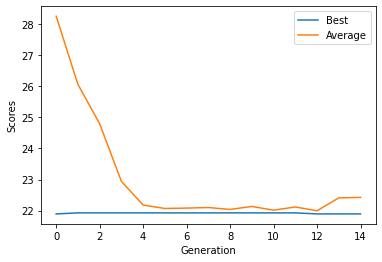

CV MSE after feature selection: 21.93


In [32]:
#==============================================================================
# CV MSE before feature selection
#==============================================================================
est = LinearRegression()
score = -1.0 * cross_val_score(est, X_train, y_train, cv=5,scoring='neg_mean_squared_error')
print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))

sel = GeneticSelector(estimator=LinearRegression(), 
                      n_gen=15, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)

sel.fit(X_train, y_train)
sel.plot_scores()
score = -1.0 * cross_val_score(est, X_train[:,sel.support_], y_train, cv=5, scoring='neg_mean_squared_error')
print("CV MSE after feature selection: {:.2f}".format(np.mean(score)))


El gráfico muestra el score promedio de la población y el del mejor cromosoma a lo largo de las generaciones. Recuerden que el score está convertido a una medida de error, por eso buscamos minimizarlo.

Podemos ver cuáles fueron las features seleccionadas usando el atributo sel.support del selector:

In [33]:
print('Features Seleccionadas:')

print(boston.feature_names[sel.support_])

Features Seleccionadas:
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B'
 'LSTAT']
